In [62]:
# === Cell: Dataset summary ===
# Purpose: Count images per split (Train/Val/Test) and per class and print a table.
# Input: Folder structure under 'cards/' (preferred). Classes = subfolders; splits = Train/Val/Test.
# Output: A table of counts per split/class and overall totals. Also reports number of images in 'testCards/' if present.

# Dataset summary: count images per split and class
from pathlib import Path
from typing import List
root = Path('cards')
preferred_splits = ['Train', 'Val', 'Test']
lower_splits = ['train', 'val', 'test']
splits: List[str] = [s for s in preferred_splits if (root / s).exists()]

# Discover classes from subfolders (union across splits if splits exist)
classes = set()
if splits:
    for s in splits:
        for d in (root / s).iterdir() if (root / s).exists() else []:
            if d.is_dir():
                classes.add(d.name)
else:
    for d in root.iterdir():
        if d.is_dir():
            classes.add(d.name)
classes = sorted(classes)

exts = {'.jpg', '.jpeg', '.png', '.bmp', '.webp'}

def count_images(dir_path: Path) -> int:
    """Count image files recursively in dir_path with supported extensions."""
    if not dir_path.exists():
        return 0
    return sum(
        1
        for p in dir_path.rglob('*')
        if p.is_file() and p.suffix.lower() in exts and not p.name.startswith('.')
    )

# Build count matrix
if splits:
    counts = {s: {c: 0 for c in classes} for s in splits}
    for s in splits:
        for c in classes:
            dir_path = root / s / c
            counts[s][c] = count_images(dir_path)
else:
    # Single-pool layout: counts only per class
    counts = {'ALL': {c: count_images(root / c) for c in classes}}
    splits = ['ALL']

# Print table
col_width = max([len(c) for c in classes] + [7]) + 2
header = "Split".ljust(8) + "".join(c.ljust(col_width) for c in classes) + "Total"
print(header)
print("-" * len(header))
grand_total = 0
per_class_totals = {c: 0 for c in classes}
for s in splits:
    row_total = sum(counts[s][c] for c in classes)
    grand_total += row_total
    for c in classes:
        per_class_totals[c] += counts[s][c]
    row = s.ljust(8) + "".join(str(counts[s][c]).ljust(col_width) for c in classes) + str(row_total)
    print(row)
print("-" * len(header))
class_row = "Total".ljust(8) + "".join(str(per_class_totals[c]).ljust(col_width) for c in classes) + str(grand_total)
print(class_row)

# Optional: preview folder used by the demo predictions
tc = Path('testCards')
if tc.exists() and tc.is_dir():
    tc_count = sum(
        1 for p in tc.iterdir() if p.is_file() and p.suffix.lower() in exts and not p.name.startswith('.')
    )

    print(f"\nPreview folder 'testCards/': {tc_count} image(s)")


Split   3HKID    3PR      4HKID    4PR      KTP      PASS     Total
-------------------------------------------------------------------
Train   132      94       116      217      92       96       747
Val     16       11       14       27       11       12       91
Test    18       13       15       28       13       12       99
-------------------------------------------------------------------
Total   166      118      145      272      116      120      937

Preview folder 'testCards/': 4 image(s)


Using weights: best.pt
Found 4 images in c:\Users\Lukita\Documents\ID Cards\testCards; evaluating 4 (first up to 4).



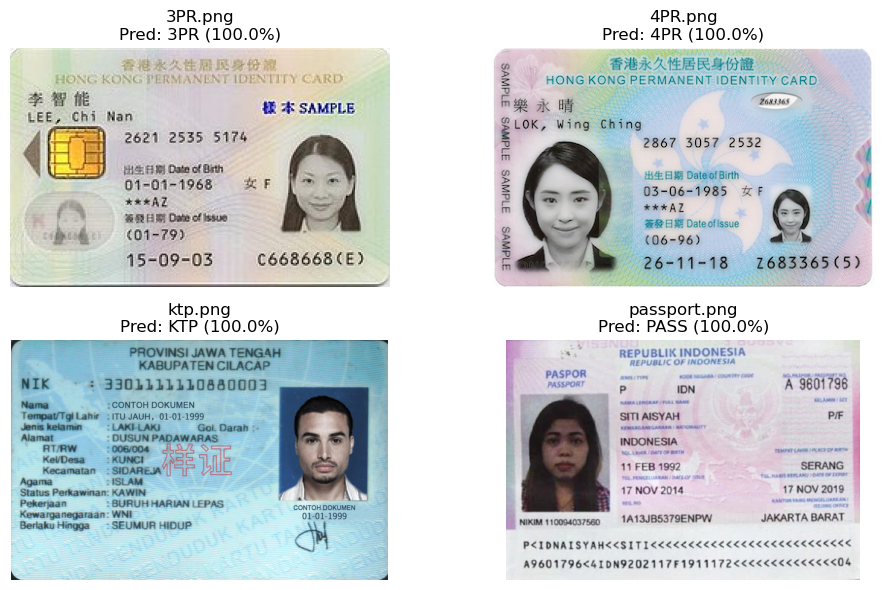

In [64]:
# === Cell: Quick prediction demo (up to 4 images) ===
# Purpose: Load best.pt and predict on up to 4 images from testCards/ (or variants).
# Input: testCards/ folder with 1–4 images (jpg/png/bmp/webp). Set IMG_SIZE (default 224) if desired.
# Output: A 2x2 grid showing each image with the top-1 predicted class and confidence.
# Predict up to 4 images from testCards directory and visualize results
from pathlib import Path
import os, glob
from typing import List
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO
# Detect weights (reuse if present)
WEIGHTS = Path('best.pt')
# Resolve folder candidates
folder_names = ['testCards', 'testcards', 'testcard', 'TestCards', 'test_Cards', 'test_card']
TEST_DIR = None
for name in folder_names:
    p = Path.cwd() / name
    if p.exists() and p.is_dir():
        TEST_DIR = p
        break
if TEST_DIR is None:
    raise FileNotFoundError("Could not find a testCards folder. Create one under the project root and add up to 4 images.")

# Collect images
exts = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.webp']
images: List[Path] = []
for pat in exts:
    images.extend(TEST_DIR.glob(pat))

images = sorted([p for p in images if p.is_file()])
if not images:
    raise FileNotFoundError(f"No images found in {TEST_DIR}. Supported extensions: jpg, jpeg, png, bmp, webp")

# Select up to 4 images for display
selected = images[:4]
print(f"Using weights: {WEIGHTS}")
print(f"Found {len(images)} images in {TEST_DIR}; evaluating {len(selected)} (first up to 4).\n")

# Load model and predict
IMG_SIZE = 224 if 'IMG_SIZE' not in globals() else int(IMG_SIZE)
model = YOLO(str(WEIGHTS))
results = model.predict(source=[str(p) for p in selected], imgsz=IMG_SIZE, workers=0, verbose=False)

# Visualize in a 2x2 grid
cols = 2
rows = (len(selected) + cols - 1) // cols
fig, axs = plt.subplots(rows, cols, figsize=(10, 6))
axs = axs.ravel() if hasattr(axs, 'ravel') else [axs]
idx_to_name = results[0].names

# Hide unused subplots if less than 4 images
for ax in axs[len(selected):]:
    ax.axis('off')

# Show each image with predicted label and confidence
for i, (p, res) in enumerate(zip(selected, results)):
    img = Image.open(p).convert('RGB')
    axs[i].imshow(img)
    axs[i].axis('off')
    top1 = int(res.probs.top1)
    top1_name = idx_to_name[top1]
    top1_conf = float(res.probs.top1conf) * 100
    axs[i].set_title(f"{p.name}\nPred: {top1_name} ({top1_conf:.1f}%)")

plt.tight_layout()
plt.show()


In [67]:
# === Cell: OCR parsing helpers (rule-based) ===
# Purpose: Given OCR output lines, extract fields like ID / Name / Date / Gender for different card types.
# Input: OCR results from PaddleOCR: a list of lines, each line is a list of word_info [bbox, (text, score)].
# Output: Short strings like 'ID <value>', 'Name <value>', 'Date <value>', 'Jenis <Male|Female>' or '' if no match.

import re
def nextWord(line, currentIndex, iniText, nextCount):
    """Safe helper to fetch a neighboring word's text in the same OCR line."""
    try:
        target_index = currentIndex + nextCount
        if 0 <= target_index < len(line):
            return iniText + str(line[target_index][1][0])
    except Exception:
        pass
    return iniText

# --- HKID v4 ---
def HKID4(line, currentWord, currentIndex):
    currentWord_clean = currentWord.strip().upper()
    key_HKID = ["IDENTITY", "CARD", "HONG", "KONG"]
    key_Birth = ["BIRTH"]
    idpattern = re.compile(r"[A-Z]{1,2}\d{5,}(\(?\d\)?)")
    match = idpattern.search(currentWord_clean)
    date_match = re.compile(r"\d{2}-\d{2}-\d{4}")
    matchDate = date_match.search(currentWord_clean)

    if matchDate:
        date_only = matchDate.group(0)
        return "Date " + date_only
    elif match:
        idOnly = match.group()
        return "ID " + idOnly



    if any(currentWord_clean.find(keyword) != -1 for keyword in key_HKID):
        theWords1 = nextWord(line, currentIndex, "", 1)
        theWords2 = nextWord(line, currentIndex, "", 2)
        theWords = "Name "
        if any(char.isdigit() for char in theWords1):
            theWords += theWords2
        else:
            theWords += theWords1
        return theWords
    return ""


# --- HKID v3 ---
def HKID3(line, currentWord, currentIndex):
    currentWord_clean = currentWord.strip().upper()
    key_HKID = ["IDENTITY", "CARD", "HONG", "KONG"]
    idpattern = re.compile(r"[A-Z]{1,2}\d{5,}(\(?\d\)?)")
    match = idpattern.search(currentWord_clean)
    date_match = re.compile(r"\d{2}-\d{2}-\d{4}")
    matchDate = date_match.search(currentWord_clean)
    if matchDate:
        date_only = matchDate.group(0)
        return "Date " + date_only
    elif match:
        idOnly = match.group()
        return "ID " + idOnly
    elif any(currentWord_clean.find(keyword) != -1 for keyword in key_HKID):
        theWords1 = nextWord(line, currentIndex, "", 1)
        theWords2 = nextWord(line, currentIndex, "", 2)
        theWords = "Name "
        if any(char.isdigit() for char in theWords1):
            theWords += theWords2
        else:
            theWords += theWords1
        return theWords
    return ""

# --- PR v3 ---
def PR3(line, currentWord, currentIndex):
    currentWord_clean = currentWord.strip().upper()
    key_HKID = ["IDENTITY", "PERMANENT", "CARD", "HONG", "KONG"]
    idpattern = re.compile(r"[A-Z]{1,2}\d{5,}(\(?\d\)?)")
    match = idpattern.search(currentWord_clean)
    date_match = re.compile(r"\d{2}-\d{2}-\d{4}")
    matchDate = date_match.search(currentWord_clean)
    if matchDate:
        date_only = matchDate.group(0)
        return "Date " + date_only
    elif match:
        idOnly = match.group()
        return "ID " + idOnly
    elif any(currentWord_clean.find(keyword) != -1 for keyword in key_HKID):
        theWords = nextWord(line, currentIndex, "", 1)
        return "Name " + theWords
    return ""

# --- PR v4 ---
def PR4(line, currentWord, currentIndex):
    currentWord_clean = currentWord.strip().upper()
    key_HKID = ["IDENTITY", "PERMANENT", "CARD", "HONG", "KONG"]
    idpattern = re.compile(r"[A-Z]{1,2}\d{5,}(\(?\d\)?)")
    match = idpattern.search(currentWord_clean)
    if match:
        idOnly = match.group()
        return "ID " + idOnly
    if any(keyword in currentWord_clean for keyword in key_HKID):
        theWords = nextWord(line, currentIndex, "", 2)
        return "Name " + theWords
    elif any(currentWord_clean.find(keyword) != -1 for keyword in ["BIRTH"]):
        theWords = nextWord(line, currentIndex, "", 1)
        return "Date " + theWords
    return ""

# --- KTP (Indonesia) ---
def KTP(line, currentWord, currentIndex):
    currentWord_clean = currentWord.strip().upper()
    key_NAME = ["NAMA"]
    Key_Kelamin = ["LAKI-LAKI", "PEREMPUAN"]
    idpattern = re.compile(r"^\d{16}$")
    date_match = re.compile(r"\d{2}-\d{2}-\d{4}")
    match = date_match.search(currentWord_clean)

    if match:
        date_only = match.group(0)
        return "Date " + date_only
    elif any(currentWord_clean.find(keyword) != -1 for keyword in key_NAME):
        theWords = nextWord(line, currentIndex, "", 1)
        date_match2 = re.compile(r".*\d{2}-\d{2}-\d{4}.*")
        if date_match2.match(str(theWords)):
            theWords = nextWord(line, currentIndex, "", -1)
        return "Name " + str(theWords)
    elif any(currentWord_clean.find(keyword) != -1 for keyword in Key_Kelamin):
        gender = "Female" if "PEREMPUAN" in currentWord_clean else "Male"
        return "Jenis " + gender
    elif idpattern.match(currentWord_clean):
        nik_number = currentWord_clean
        return "ID " + nik_number
    return ""

# --- Passport ---
def PASS(line, currentWord, currentIndex):
    currentWord_clean = currentWord.strip().upper()
    key_NAME = ["NAMA", "LENGKAP", "FULL"]
    key_Jenis = ["PIF", "P/F", "L/M", "LIM"]
    idpattern = re.compile(r"^[A-Z]{1}\d{7}$")
    idpattern2 = re.compile(r"^[A-Z]{2}\d{5,}$")
    date_pattern = re.compile(r"\s*\d{2}\s*[A-Z]{3}\s*\d{4}\s*")

    if any(currentWord_clean.find(keyword) != -1 for keyword in key_NAME):
        theWords = nextWord(line, currentIndex, "", 1)
        return "Name " + str(theWords)
    elif date_pattern.match(currentWord_clean):
        return "Date " + currentWord_clean
    elif any(currentWord_clean.find(keyword) != -1 for keyword in key_Jenis):
        gender = "Female" if any(currentWord_clean.find(k) != -1 for k in ["PIF", "P/F"]) else "Male"
        return "Jenis " + gender
    elif idpattern.match(currentWord_clean) or idpattern2.match(currentWord_clean):
        return "ID " + currentWord_clean
    return ""



image 1/1 c:\Users\Lukita\Documents\ID Cards\test.jpg: 640x640 4HKID 1.00, KTP 0.00, 3PR 0.00, PASS 0.00, 3HKID 0.00, 30.3ms
Speed: 6.7ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
image 1/1 c:\Users\Lukita\Documents\ID Cards\test.jpg: 640x640 4HKID 1.00, KTP 0.00, 3PR 0.00, PASS 0.00, 3HKID 0.00, 30.3ms
Speed: 6.7ms preprocess, 30.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


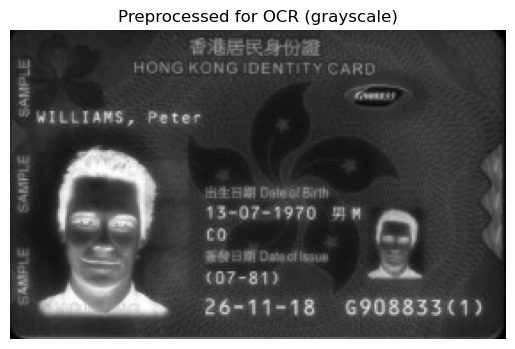

[2025/10/22 18:58:36] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\Lukita/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\Lukita/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_l

In [68]:
# === Cell: Classification + OCR demo on single image ===
# Purpose: Classify 'test.jpg' using best.pt, then run OCR (PaddleOCR) on a preprocessed version and parse key fields.
# Input: test.jpg in project root. Requires PaddleOCR installed for the OCR step.
# Output: Prints predicted class and parsed fields (ID/Name/Date/Gender). Also shows the grayscale image used for OCR.

from ultralytics import YOLO
import numpy as np
import cv2
from paddleocr import PaddleOCR
import matplotlib.pyplot as plt
import requests
from io import BytesIO
# Image path (update if needed)
image_url = "test.jpg"
# Load image for preprocessing/visualization
image = cv2.imread(image_url)
model = YOLO('best.pt')
names = model.names
# Run classification to determine document type
results = model(image_url)
predicted_name = ""
for result in results:
    probs = result.probs
    top1_index = probs.top1
    predicted_name = names[top1_index]

# Simple preprocessing for OCR: negative + grayscale
negative_image = 255 - image
gray_image = cv2.cvtColor(negative_image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap='gray')
plt.title("Preprocessed for OCR (grayscale)")
plt.axis('off')
plt.show()

# Run OCR (requires PaddleOCR installed)
ocr = PaddleOCR(use_angle_cls=True, lang='en')
ocr_results = ocr.ocr(gray_image, cls=True)

# # Debug: print raw OCR words
# for line in ocr_results:
#     for word_info in line:
#         print(word_info[1][0])

# Process OCR results with rule-based parsers
print("Card Type:", predicted_name)
identify = str(predicted_name)
myID2 = ""
myName = ""
myDate = ""
myGender = ""
dfImages = []
for line in ocr_results:
    for index, word_info in enumerate(line):
        myID = ""
        if identify == "3HKID":
            myID = HKID3(line, word_info[1][0], index)
        elif identify == "4HKID":
            myID = HKID4(line, word_info[1][0], index)
        elif identify == "3PR":
            myID = PR3(line, word_info[1][0], index)
        elif identify == "4PR":
            myID = PR4(line, word_info[1][0], index)
        elif identify == "KTP":
            myID = KTP(line, word_info[1][0], index)
        elif identify == "PASS":
            myID = PASS(line, word_info[1][0], index)
        if myID.startswith("ID"):
            myID2 = myID.split()[-1]
        elif myID.startswith("Name"):
            myName = myID.split()[-1]
        elif myID.startswith("Date"):
            # capture first Date we find (with slight special-case for KTP)
            if myDate == "" and identify == "KTP":
                myDate = myID.split()[-1]
            elif myDate == "" and identify != "KTP":
                myDate = myID.split()[-1]
            elif myDate == "":
                myDate = myID.split()[-1]
        elif myID.startswith("Jenis"):
            myGender = myID.split()[-1]


# Aggregate and print final results
dfImages.append((image_url, myID2, myName, myGender, myDate))
print("Final Results:", dfImages)
print("-------------------------------------------")
print("ID: "+myID2)
print("name: "+myName)
print("Date: "+myDate)
print("-------------------------------------------")


In [ ]:
!pip install paddlepaddle==2.6.1 paddleocr==2.7.3 opencv-python-headless>=4.5 --user

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ultralytics 8.3.153 requires torch!=2.4.0,>=1.8.0; sys_platform == "win32", which is not installed.
ultralytics 8.3.153 requires torch>=1.8.0, which is not installed.
ultralytics 8.3.153 requires torchvision>=0.9.0, which is not installed.
